In [116]:
import wget
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.model_selection
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_extraction import DictVectorizer
import sklearn.metrics
from sklearn.tree import export_text
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import re



In [41]:
data = wget.download("https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv")

In [42]:
df = pd.read_csv(data)
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [43]:
df = df.fillna(0)
df.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

In [44]:
df_full_train, df_test = sklearn.model_selection.train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = sklearn.model_selection.train_test_split(df, test_size=0.25, random_state=1)

y_train = np.log1p(df_train.median_house_value.values)
y_val = np.log1p(df_val.median_house_value.values)
y_test = np.log1p(df_test.median_house_value.values)

del df_train['median_house_value']
del df_test['median_house_value']
del df_val['median_house_value']

In [45]:
dv = DictVectorizer(sparse=False)

traind = df_train.to_dict(orient='records')
vald = df_val.to_dict(orient='records')
testd = df_test.to_dict(orient='records')

x_train = dv.fit_transform(traind)
x_val = dv.transform(vald)


#### Q1

In [48]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(x_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [50]:
print(export_text(dt, feature_names=dv.get_feature_names()))

|--- ocean_proximity=INLAND <= 0.50
|   |--- value: [12.31]
|--- ocean_proximity=INLAND >  0.50
|   |--- value: [11.61]



c:\Users\aaish\Documents\AaishaM\mlzoomcamp\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


#### Q2

In [60]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(x_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [66]:
y_pred = rf.predict(x_val)
np.sqrt(sklearn.metrics.mean_squared_error(y_val, y_pred)).round(2)

0.24

#### Q3 - Best n_estimators

In [73]:
rmse_scores = {}

for i in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=i, random_state=1, n_jobs=-1)
    rf.fit(x_train, y_train)
    y_pred = rf.predict(x_val)
    score = np.sqrt(sklearn.metrics.mean_squared_error(y_val, y_pred))

    rmse_scores[i] = round(score, 5)

rmse_scores

{10: 0.24463,
 20: 0.2392,
 30: 0.23671,
 40: 0.23599,
 50: 0.23518,
 60: 0.23483,
 70: 0.23502,
 80: 0.23466,
 90: 0.23457,
 100: 0.23462,
 110: 0.23464,
 120: 0.23464,
 130: 0.23435,
 140: 0.23427,
 150: 0.23424,
 160: 0.23425,
 170: 0.23424,
 180: 0.23417,
 190: 0.23412,
 200: 0.23409}

#### Q4 - best max_depth

In [74]:
depths = [10, 15, 20, 25]
depth_scores = []

for x in depths:
    for i in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=i, max_depth=x, random_state=1, n_jobs=-1)
        rf.fit(x_train, y_train)
        y_pred = rf.predict(x_val)
        score = np.sqrt(sklearn.metrics.mean_squared_error(y_val, y_pred)).round(5)

        depth_scores.append((x, i, score))

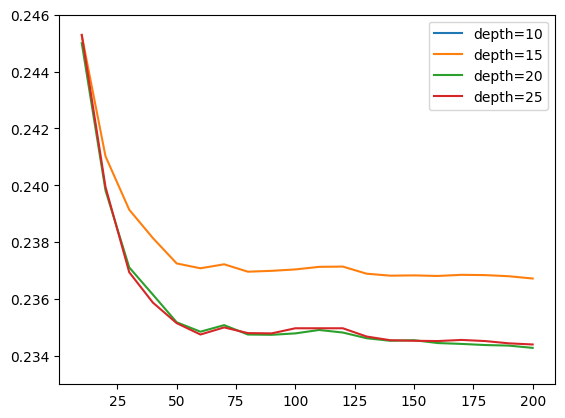

In [81]:
depth_scores_df = pd.DataFrame(depth_scores, columns=['Depths', 'n_est', 'rmse'])
for depth in depths:
    depth_df = depth_scores_df[depth_scores_df['Depths']==depth]
    plt.plot(depth_df['n_est'], depth_df['rmse'], label='depth=%d' % depth)

plt.legend()
plt.ylim(0.233, 0.246)
plt.show()

#### Q5

In [82]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rf.fit(x_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [105]:
importances = rf.feature_importances_
features = dv.get_feature_names()
feature_importance = pd.DataFrame(importances, index=features)
feature_importance

c:\Users\aaish\Documents\AaishaM\mlzoomcamp\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,0
households,0.017499
housing_median_age,0.032054
latitude,0.103855
longitude,0.095771
median_income,0.347414
ocean_proximity=<1H OCEAN,0.002472
ocean_proximity=INLAND,0.325677
ocean_proximity=ISLAND,0.000097
ocean_proximity=NEAR BAY,0.000244
ocean_proximity=NEAR OCEAN,0.003752


<AxesSubplot:>

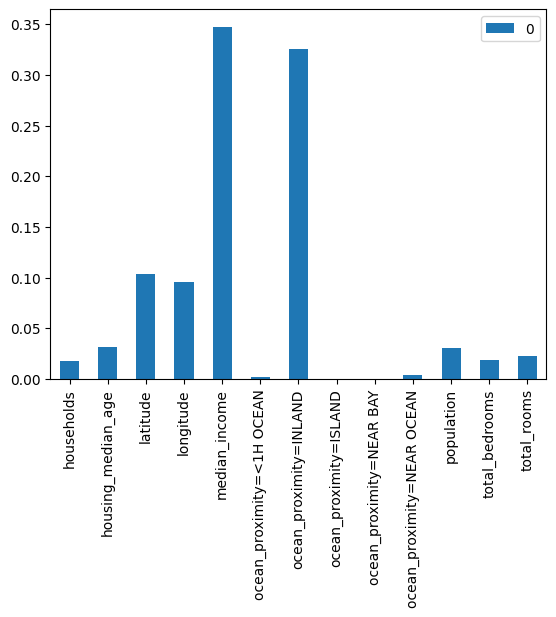

In [109]:
feature_importance.plot.bar()

#### Q6

In [118]:
features = dv.feature_names_

regex = re.compile(r"<", re.IGNORECASE)
features = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in features]

dtrain = xgb.DMatrix(x_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(x_val, label=y_val, feature_names=features)

In [119]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

In [124]:
model = xgb.train(xgb_params, dtrain, num_boost_round=100)
y_pred = model.predict(dval)
np.sqrt(sklearn.metrics.mean_squared_error(y_val, y_pred)).round(3)

0.231

In [125]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100)
y_pred = model.predict(dval)
np.sqrt(sklearn.metrics.mean_squared_error(y_val, y_pred)).round(3)

0.234

In [126]:
xgb_params = {
    'eta': 0.01, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100)
y_pred = model.predict(dval)
np.sqrt(sklearn.metrics.mean_squared_error(y_val, y_pred)).round(3)

4.25